In [3]:
import torch
import numpy as np
import sys

import matplotlib.pyplot as plt

sys.path.insert(0,'../pulp-frontnet/PyTorch')
sys.path.insert(0,'../adversarial_frontnet/')
from Frontnet.Frontnet import FrontnetModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from util import load_dataset, load_model
model_path = '../pulp-frontnet/PyTorch/Models/Frontnet160x32.pt'
model_config = '160x32'
# dataset_path = '../pulp-frontnet/PyTorch/Data/160x96StrangersTestset.pickle'

In [5]:
model = load_model(path=model_path, device=device, config=model_config)
model.eval()
# dataset = load_dataset(path=dataset_path, batch_size=32, shuffle=False, drop_last=True, num_workers=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [29]:
camera_intrinsics = np.load("camera_intrinsic.npy")
camera_extrinsics = np.load("full_translate.npy")

In [105]:
import os
path = "eval_custom_patch/rgb_small_person/"
os.makedirs(path, exist_ok=True)

In [1]:
import glob

In [106]:
images = []
for i, np_name in enumerate(sorted(glob.glob('/home/pia/Crazyflie/aideck-gap8-examples/rgb-large-person/raw/*.npy'))[:]):
    images.append(np.load(np_name))

images = torch.tensor(images, device=device).unsqueeze(1).float()

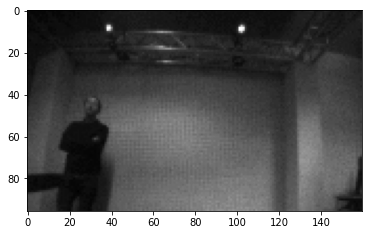

In [107]:
plt.imshow(images[0, 0].numpy(), cmap='gray')

In [108]:
all_outputs = torch.stack(model(images[:])).permute(1, 0, 2).squeeze(2)

In [109]:
np.save(path+'frontnet_out', all_outputs.detach().numpy())

In [110]:
all_outputs[0, :3]

tensor([1.7743, 0.6171, 0.3783], grad_fn=<SliceBackward0>)

In [111]:
u, v, w = camera_intrinsics @ camera_extrinsics @ torch.hstack((all_outputs[:, :3], torch.ones(all_outputs.shape[0], 1))).detach().numpy().T
img_x = u/w
img_y = v/w

print(img_x.shape, img_y.shape)

(2135,) (2135,)


In [112]:
for i in range(all_outputs.shape[0]):
    plt.imshow(images[i, 0].detach().numpy(), cmap='gray')
    plt.scatter(img_x[i], img_y[i])
    plt.savefig(path+f"projected_{i:06d}.jpg", dpi=200)
    plt.close()